Notebook to create ESG index for sectors and industries. It also subtracts shifts.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma
import datetime
import scipy
import importlib
import os, sys
sys.path.insert(0, 'C:/Users/User/Code/MMDGraph')
import Gibbs
import seaborn as sns
import tqdm
from pandas_datareader import data

In [6]:

def plot_esg_industry(sector, asset_profiles, esg_data):
    industries = np.unique(asset_profiles['industry'].loc[asset_profiles['sector'] == sector])

    k = len(industries)

    fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,5*(int(k/4)+1)))
        

    for idx, industry in enumerate(industries):

        j = idx % 4
        i = int(np.floor(idx/4)) 
        
        companies_in_industry = list(asset_profiles['ticker'].loc[asset_profiles['industry'] == industry])
        axs[i,j].set_title(industry)
        if np.sum(esg_data.columns.isin(companies_in_industry)) == 0:
            print(f'No esg data on companies in industry {industry}')
            continue
        companies = esg_data.loc[:, esg_data.columns.isin(companies_in_industry)]

        for ticker in companies.columns:
            
            y = esg_data[ticker]
            ymask = np.isfinite(y)
            x = esg_data.index[ymask]
            axs[i,j].plot(x, y[ymask], alpha = 0.4)

def find_jump(y):
    """
    Returns
    -------------------------
    jump_index - index when jump occurs
    jump_index_prev - number of observation (nan not included) before jump
    biggest_jump_direction - size of the jump and direction (minus is jump down)


    
    """

    biggest_jump = 0
    biggest_jump_direction = 0
    prev_value = y[0,0]  # previous non nan value
    jump_index = 0
    jump_index_prev = 0

    observations = [0]
    for i in range(1,y.shape[0]):

        if np.isnan(y[i,0]):
            continue

        observations.append(i)


        this_jump = np.abs(y[i,0] - prev_value)
        this_jump_direction = y[i,0] - prev_value
        if this_jump > biggest_jump:
            biggest_jump = this_jump
            biggest_jump_direction = this_jump_direction
            jump_index_prev = observations[-2]
            jump_index = i

        prev_value = y[i,0]

    return jump_index, jump_index_prev, biggest_jump_direction

# Read data

In [3]:
PRICE = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")
ESG_data = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'ESG')
TICKERS = np.unique(ESG_data['ticker'])
companies = np.unique(PRICE['ticker']) 
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 


esg_series = ESG_data.copy()  #ESG_data.loc[ESG_data['ticker'] == 'BMY'].copy()
esg_series['timestamp'] = pd.to_datetime(esg_series['timestamp'])
min_date = datetime.datetime(2014,10, 1)
max_date = np.max(ESG_data['timestamp'])
esg_series['date'] = esg_series['timestamp'].dt.date
print(min_date)
print(max_date)
esg_series


# Create a series of days, which will then be joined with esg_series, To create "daily" ESG.
dates = pd.DataFrame({'date':pd.date_range(min_date,max_date,freq='d')})
dates['date'] = dates['date'].dt.date

# create an esg data frame where index is monthly
esg_pivot = esg_series[['ticker', 'esgScore', 'date']].copy()
esg_pivot_diff =pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker').diff().iloc[1:]#  np.log(pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker').pct_change().iloc[1:] + 1)
esg_pivot = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker')
esg_pivot = pd.merge(dates, esg_pivot, how = 'left', left_on='date', right_index=True)
esg_pivot_diff = pd.merge(dates, esg_pivot_diff, how = 'left', left_on='date', right_index=True)
esg_pivot.set_index('date', inplace= True)
esg_pivot_diff.set_index('date', inplace= True)
esg_pivot = esg_pivot.loc[:, esg_pivot.count() >20]  # remove observations with lass than 10 observations
esg_pivot_diff = esg_pivot_diff.loc[:, esg_pivot_diff.count() >20]



asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 

esg_pivot_enough_data = esg_pivot.loc[:,~np.isnan(esg_pivot.iloc[0,:])]
sector_classification = dict()
for company in esg_pivot_enough_data.columns:
    sector_of_company = asset_profiles['sector'].loc[asset_profiles['ticker'] == company].iloc[0]
    if sector_of_company not in sector_classification.keys():
        sector_classification[sector_of_company] = list()
    sector_classification[sector_of_company].append(company)

esg_pivot



2014-10-01 00:00:00
2022-02-01 00:00:00


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,PSX,PYPL,RE,SCHW,STZ,T,TAP,WRB,XOM,XRAY
date,,,,,,,,,,,,,,,,,,,,,
2014-10-01,71.00,73.00,48.00,60.00,62.00,55.00,64.00,72.00,70.00,64.00,...,53.00,NaN,45.00,50.00,54.0,65.00,73.0,45.00,65.00,57.00
2014-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
np.max(esg_pivot_diff.count())

75

In [4]:
sector_classification.keys()

dict_keys(['Healthcare', 'Industrials', 'Consumer Cyclical', 'Technology', 'Consumer Defensive', 'Utilities', 'Financial Services', 'Basic Materials', 'Real Estate', 'Energy', 'Communication Services'])

In [5]:
for k,v in sector_classification.items():
    print(f'{k} {len(v)}')

Healthcare 39
Industrials 43
Consumer Cyclical 34
Technology 40
Consumer Defensive 26
Utilities 21
Financial Services 46
Basic Materials 14
Real Estate 15
Energy 14
Communication Services 15


# Single company data frame

Plot some examples

In [6]:
sector_classification['Industrials']

['AAL',
 'ADP',
 'ALLE',
 'AME',
 'AVY',
 'BA',
 'CAT',
 'CHRW',
 'CMI',
 'CPRT',
 'CSX',
 'CTAS',
 'DAL',
 'DE',
 'DOV',
 'EFX',
 'EMR',
 'ETN',
 'EXPD',
 'FAST',
 'FDX',
 'GD',
 'GE',
 'GPN',
 'GWW',
 'HON',
 'IEX',
 'IR',
 'ITW',
 'J',
 'JBHT',
 'JCI',
 'LMT',
 'MAS',
 'MMM',
 'NDSN',
 'NLSN',
 'NOC',
 'NSC',
 'PAYX',
 'PCAR',
 'PH',
 'PNR']

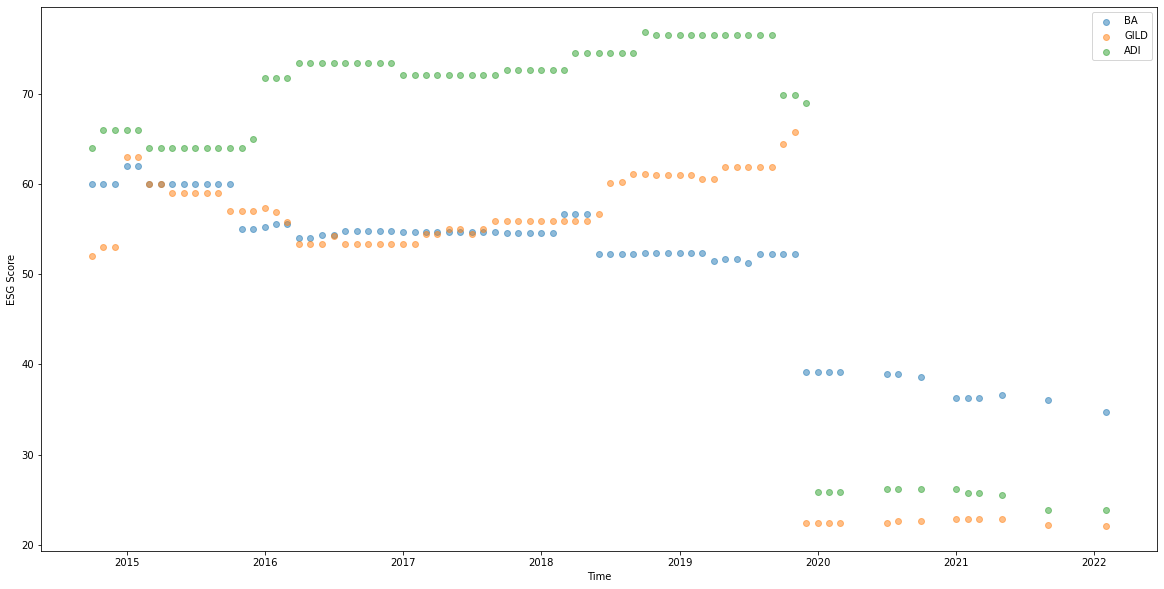

In [7]:
fig, ax = plt.subplots(1,1, figsize = (20,10))

for i, stock in enumerate(['BA', 'GILD', 'ADI']):
    ax.scatter(esg_pivot.index, esg_pivot.loc[:,stock], alpha = 0.5, label = stock)
    ax.set_ylabel("ESG Score")
    ax.set_xlabel("Time")

ax.legend()

Subtract the shift of each series by subtracting the mean before and after for each series

In [8]:
esg_pivot_shifted = esg_pivot.copy()

for stock in esg_pivot.columns:
    y_tmp = np.expand_dims(esg_pivot.loc[:,stock], axis = 1)  # the function assumes 2 dimensional array
    index, _, _ = find_jump(y_tmp)
    esg_pivot_shifted[stock].iloc[:index] = np.nanmean(esg_pivot[stock].iloc[index:]) - np.nanmean(esg_pivot[stock].iloc[:index]) + esg_pivot[stock].iloc[:index]


Visualize changes

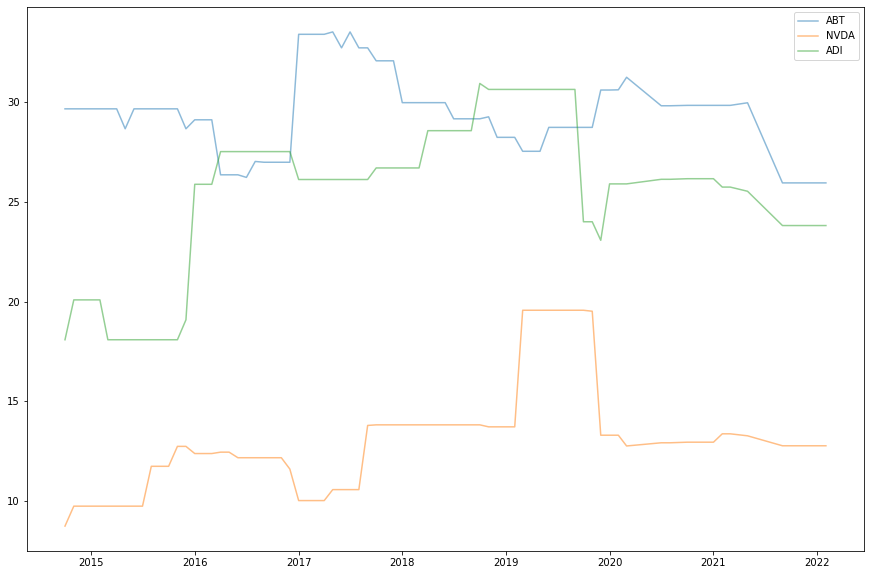

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for ticker in ['ABT', 'NVDA', 'ADI']:
    x = np.array(esg_pivot_shifted.index)
    y = np.array(esg_pivot_shifted[ticker])
    ymask = np.isfinite(y)
    out = ax.plot(x[ymask], y[ymask], alpha = 0.5)
    legend_ticks.append(ticker)

plt.legend(legend_ticks)

Calculate difference of shifted series and save

In [10]:
esg_pivot_shifted_refined_diff = []
for i in range(esg_pivot_shifted.shape[1]):
    diff = esg_pivot_shifted.iloc[:,i].dropna().diff().iloc[1:]
    esg_pivot_shifted_refined_diff.append(diff)

esg_pivot_shifted_refined_diff = pd.merge(pd.DataFrame(index = esg_pivot_shifted.index[esg_pivot_shifted.index >= datetime.date(2014,11, 1)])
,pd.concat(esg_pivot_shifted_refined_diff, axis = 1), left_index = True, right_index = True, how = 'left')

Visualize and save

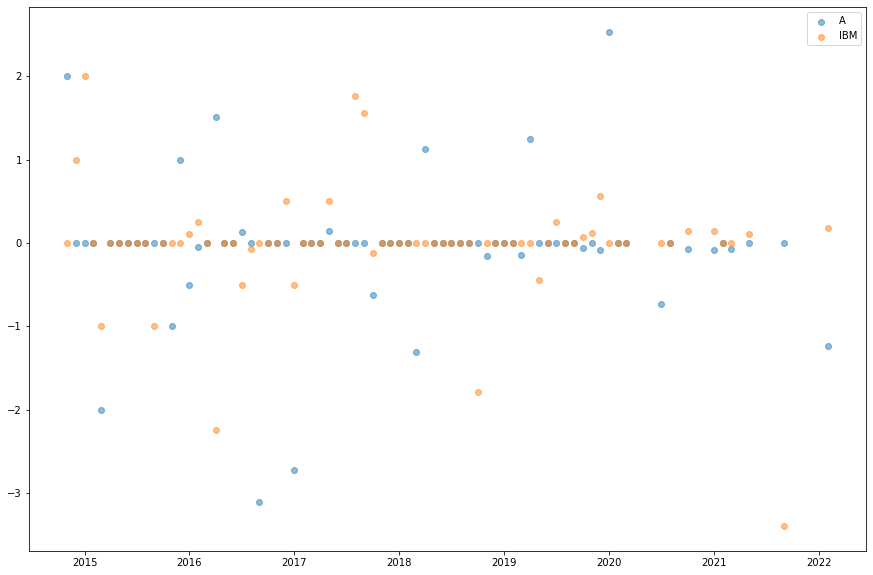

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for ticker in esg_pivot_shifted.columns[::200]:
    x = np.array(esg_pivot_shifted_refined_diff.index)
    y = np.array(esg_pivot_shifted_refined_diff[ticker])
    ymask = np.isfinite(y)
    out = ax.scatter(x[ymask], y[ymask], alpha = 0.5)
    legend_ticks.append(ticker)

plt.legend(legend_ticks)

In [12]:
esg_pivot_shifted_refined_diff.to_pickle('../Yahoo/refined.pkl')

# Sector index

Create an index for each sector by weighting ESG scores with market cap

In [13]:
# for loop to see which company fails
marketcap = pd.DataFrame()
for ticker in list(esg_pivot_shifted_refined_diff.columns):
    try:
        tmp_mcap = data.get_quote_yahoo(ticker)['marketCap']
        marketcap  = pd.concat([marketcap, pd.DataFrame({"ticker":ticker, "marketcap":tmp_mcap[0]/1000000}, index=[0])] )
    except:
        print(f"{ticker} failed") 


DISCA failed
HON failed


In [128]:
np.sum(~np.isnan(esg_pivot_shifted_refined_diff['DISCA']))

74

In [131]:
# add manually for DISCA
marketcap = pd.concat([marketcap, pd.DataFrame({"ticker":'DISCA', "marketcap":12.39*1000000000/1000000}, index=[0])] )

Build sector index

marketcap weighted sector esg index

In [132]:
index_dict = dict()

for k, v in sector_classification.items():

    index_dict[k] = np.zeros(esg_pivot_shifted.shape[0])

    market_cap_sum = np.sum(marketcap.loc[np.isin(marketcap['ticker'], v), 'marketcap'])
    
    for ticker in v:

        
        tmp = np.array(esg_pivot_shifted[ticker])
        tmp[np.isnan(esg_pivot_shifted[ticker])] = 0

        index_dict[k] = index_dict[k] + tmp*marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'][0]/market_cap_sum

    # if the index is zero, all esg scores are nan
    index_dict[k][index_dict[k] == 0] = np.nan



index_dict = pd.DataFrame(index_dict)
index_dict.index = esg_pivot_shifted.index.copy()

KeyError: 0

In [9]:
# index_dict = pd.read_pickle("../Yahoo/sector_index_no_diff.pkl")

Text(0, 0.5, 'ESG Score')

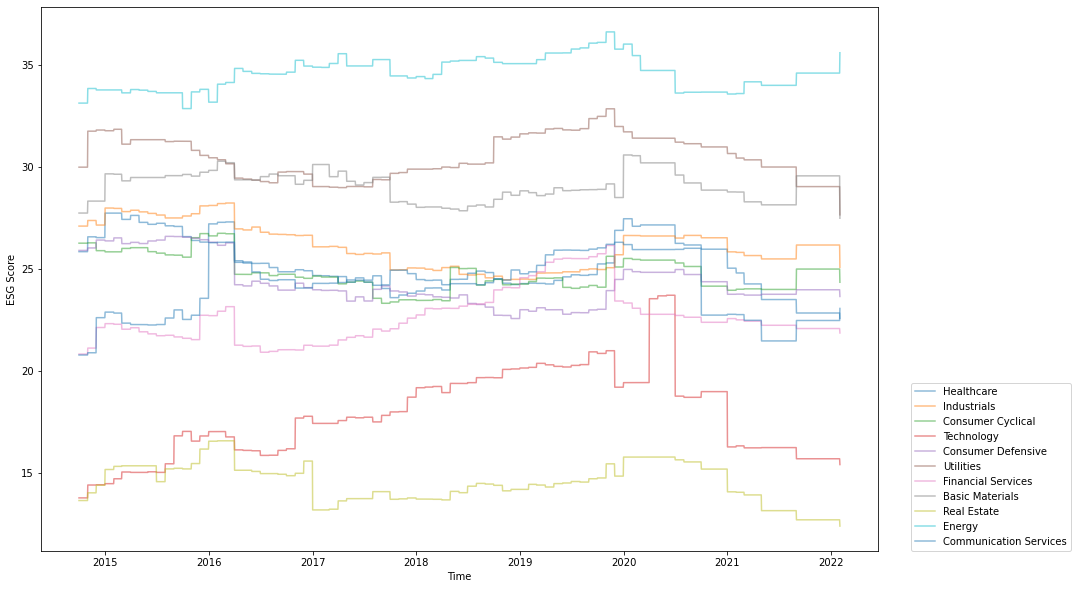

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for sector in index_dict.columns:

    y = index_dict[sector].fillna(method='ffill')

    out = ax.plot(index_dict.index, y, alpha = 0.5, label = sector)
    # legend_ticks.append(sector)

ax.legend(loc=(1.04,0))
ax.set_xlabel("Time")
ax.set_ylabel("ESG Score")

Take Difference of sectors

In [ ]:
index_dict_diff = []
for i in range(index_dict.shape[1]):
    diff = index_dict.iloc[:,i].dropna().diff().iloc[1:]
    index_dict_diff.append(diff)

index_dict_diff = pd.merge(pd.DataFrame(index = index_dict.index[index_dict.index >= datetime.date(2014,11, 1)])
,pd.concat(index_dict_diff, axis = 1), left_index = True, right_index = True, how = 'left')

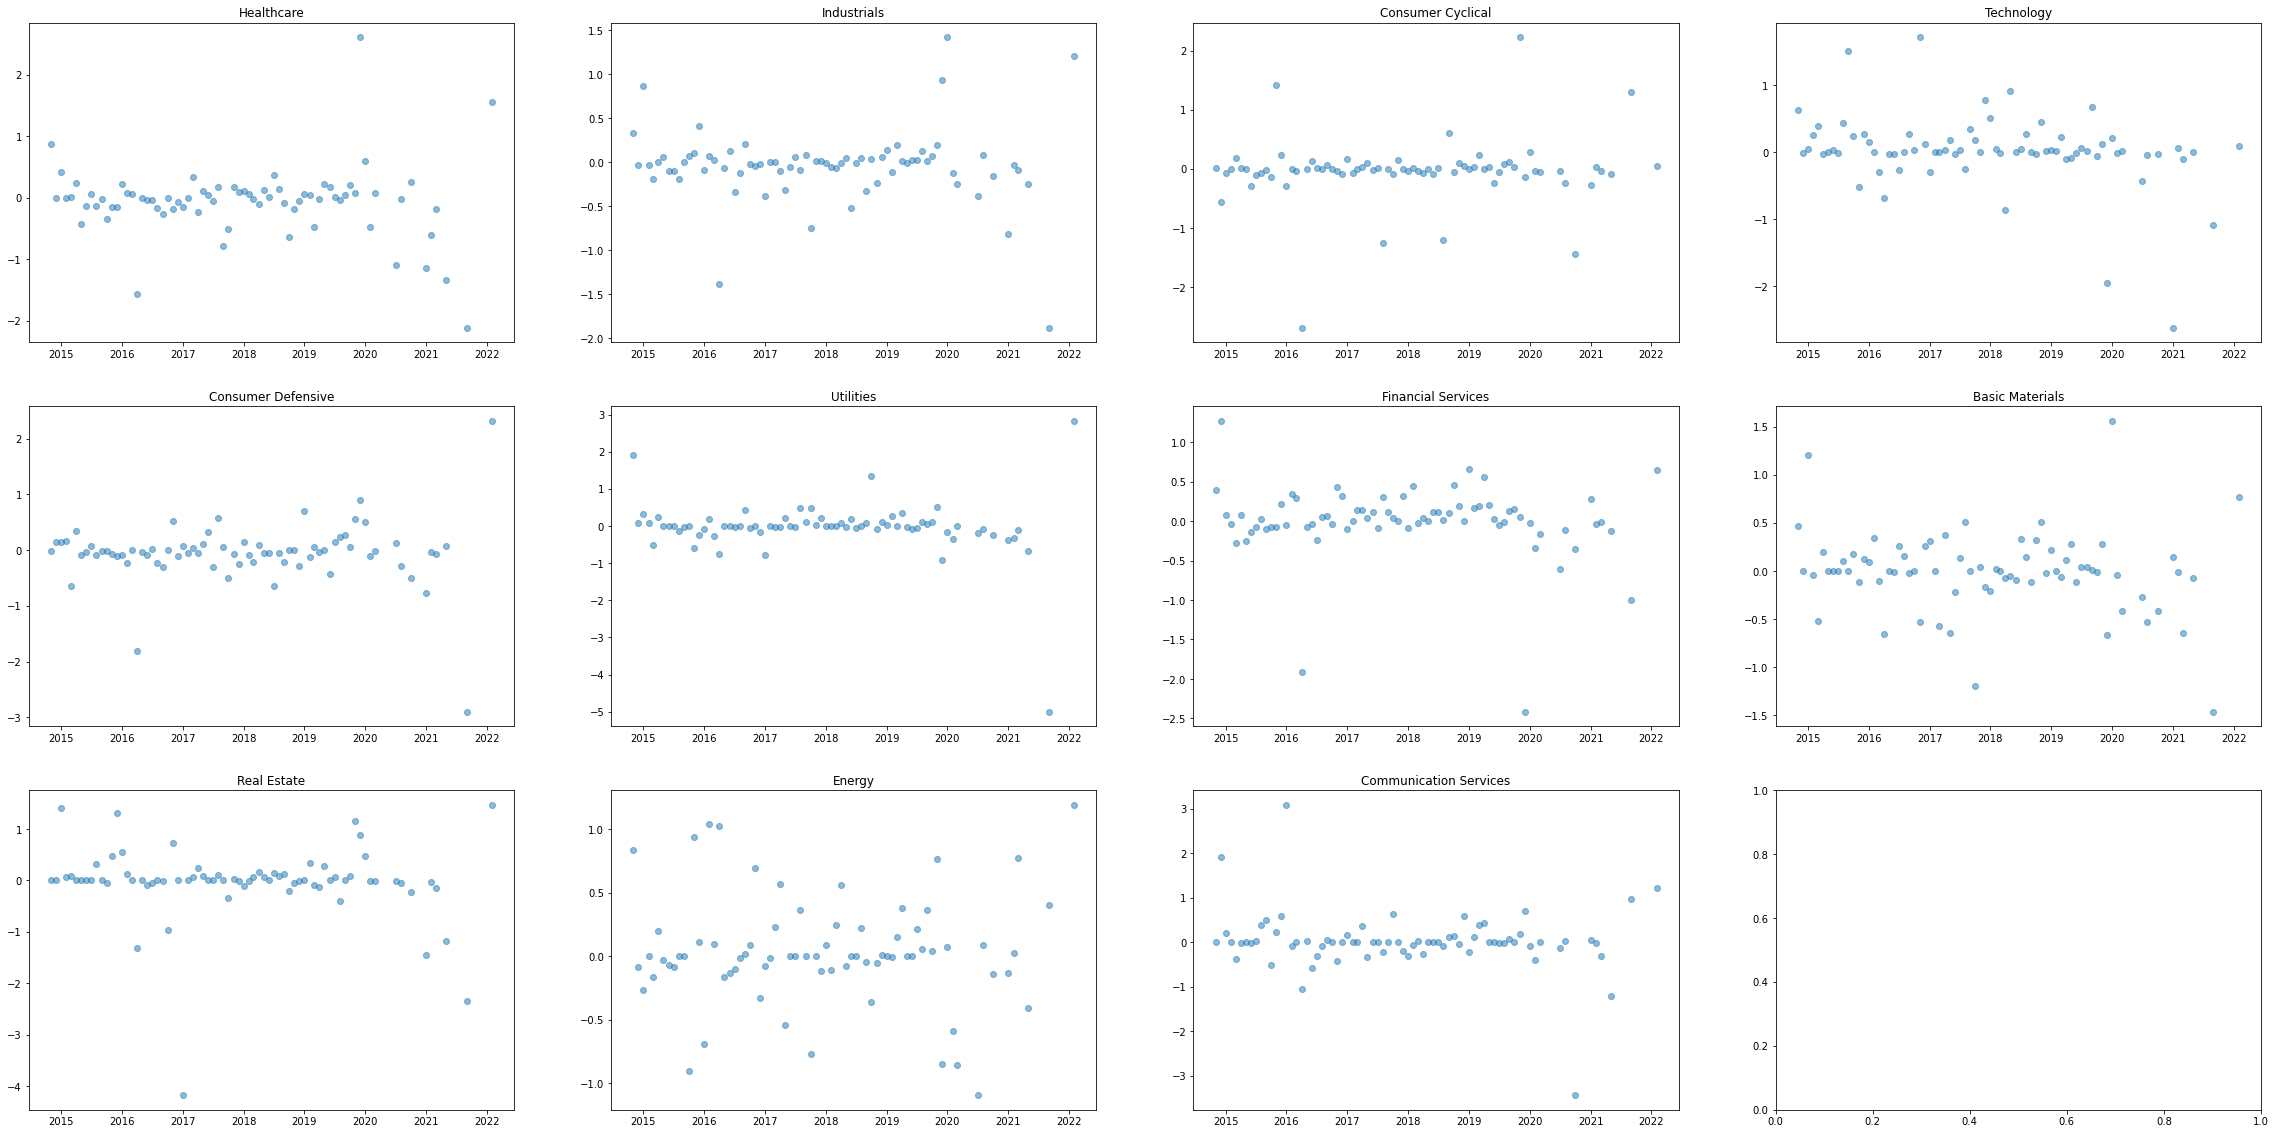

In [ ]:


fig, ax = plt.subplots( 3, 4, figsize = (40,20))
for idx, sector in enumerate(index_dict_diff.columns):

    j = idx % 4
    i = int(np.floor(idx/4))

    y = index_dict_diff[sector]

    ax[i,j].scatter(index_dict_diff.index, y, alpha = 0.5, label = sector)
    ax[i,j].set_title(sector)



Looks better than individual stocks

In [ ]:
# index_dict_diff.to_pickle('../Yahoo/sector_index.pkl')

# Industry index

In [ ]:
def industry_index(sector, asset_profiles,esg_pivot_shifted, marketcap):
    index_dict = dict()

    industries = np.unique(asset_profiles['industry'].loc[asset_profiles['sector'] == sector])

    k = len(industries)

    
    industry_classification = dict()
    for idx, industry in enumerate(industries):

        
        industry_classification[industry] = list(asset_profiles['ticker'].loc[asset_profiles['industry'] == industry])

    for k, v in industry_classification.items():
        if len(v) <=0:
            continue

        index_dict[k] = np.zeros(esg_pivot_shifted.shape[0])

        market_cap_sum = np.sum(marketcap.loc[np.isin(marketcap['ticker'], v), 'marketcap'])

        
        
        for ticker in v:

            
            tmp = np.array(esg_pivot_shifted[ticker])
            tmp[np.isnan(esg_pivot_shifted[ticker])] = 0

            index_dict[k] = index_dict[k] + tmp*marketcap.loc[marketcap['ticker'] == ticker, 'marketcap'][0]/market_cap_sum

        # if the index is zero, all esg scores are nan
        index_dict[k][index_dict[k] == 0] = np.nan



    index_dict = pd.DataFrame(index_dict)
    index_dict.index = esg_pivot_shifted.index.copy()

    return index_dict

# Industrial sector industry

No esg data on companies in industry Rental & Leasing Services
No esg data on companies in industry Tools & Accessories
No esg data on companies in industry Trucking
No esg data on companies in industry Waste Management


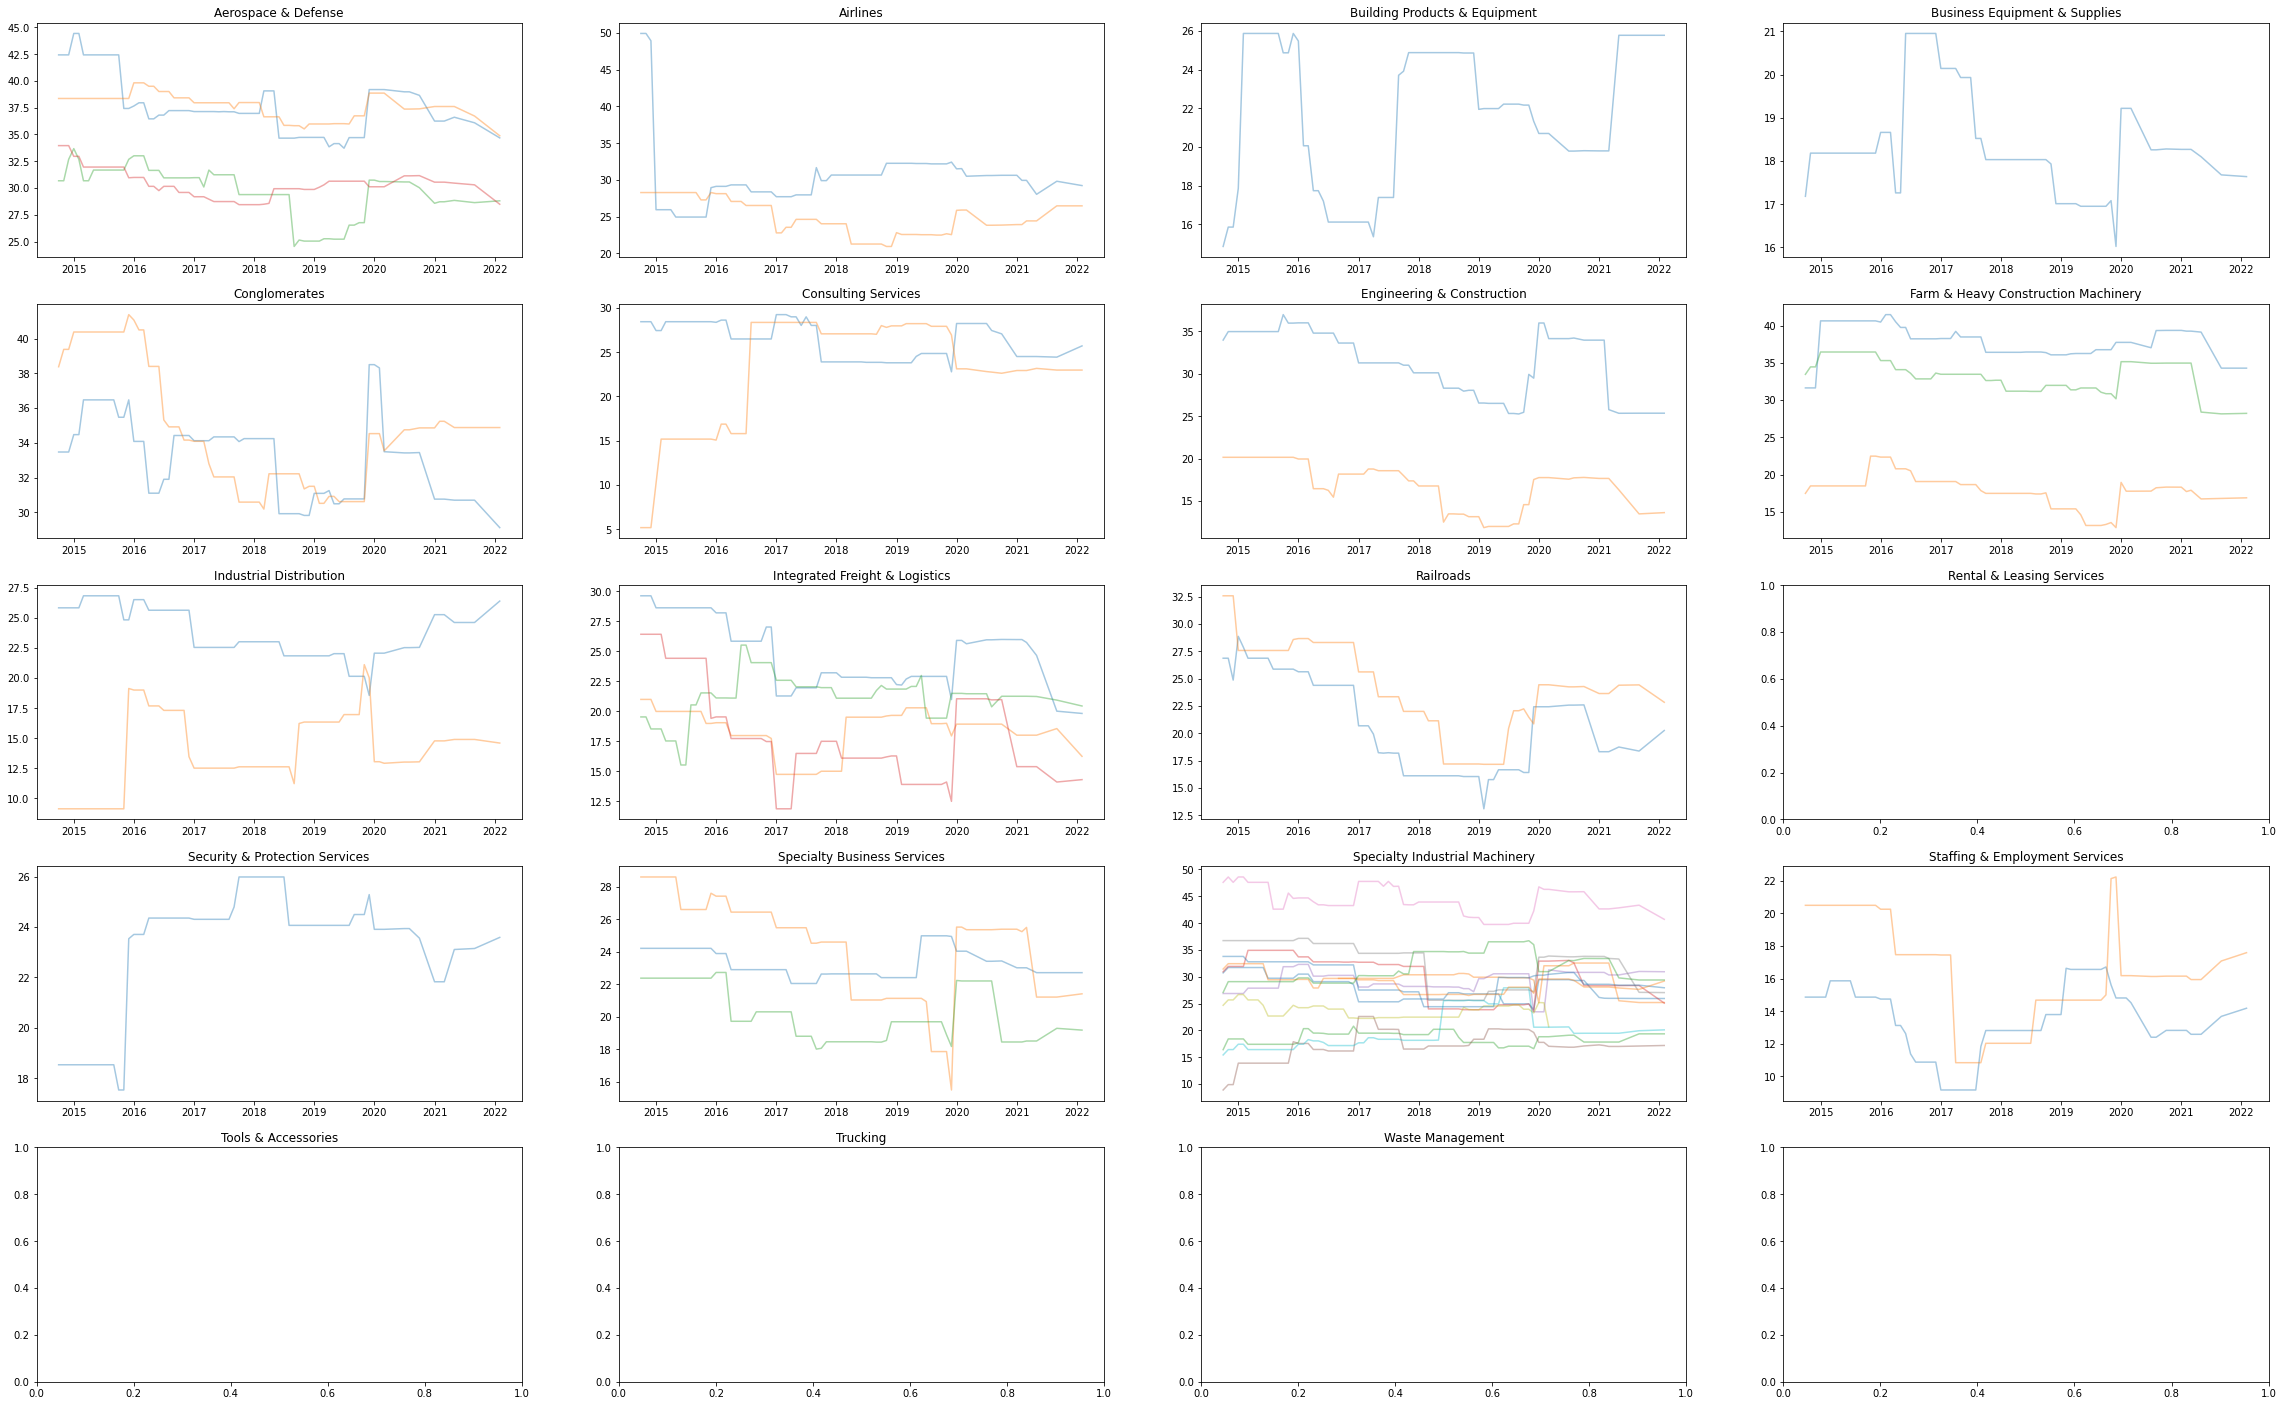

In [ ]:
plot_esg_industry('Industrials', asset_profiles, esg_pivot_shifted)

In [ ]:
industry_index("Industrials", asset_profiles, esg_pivot_shifted, marketcap)

# Energy

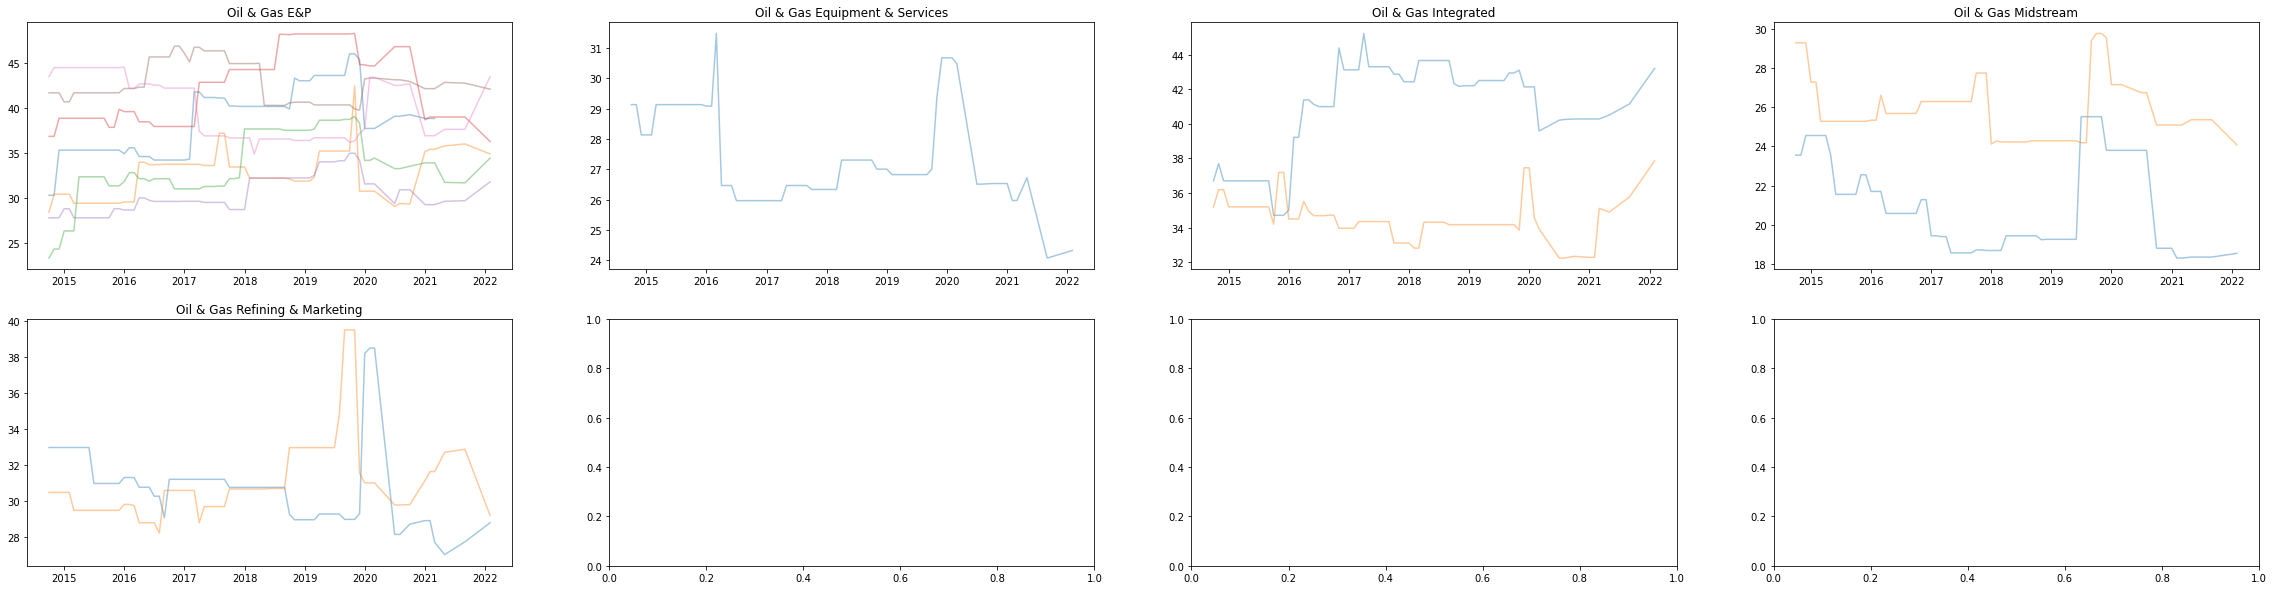

In [119]:
plot_esg_industry('Energy', asset_profiles, esg_pivot_shifted)

# Utilities

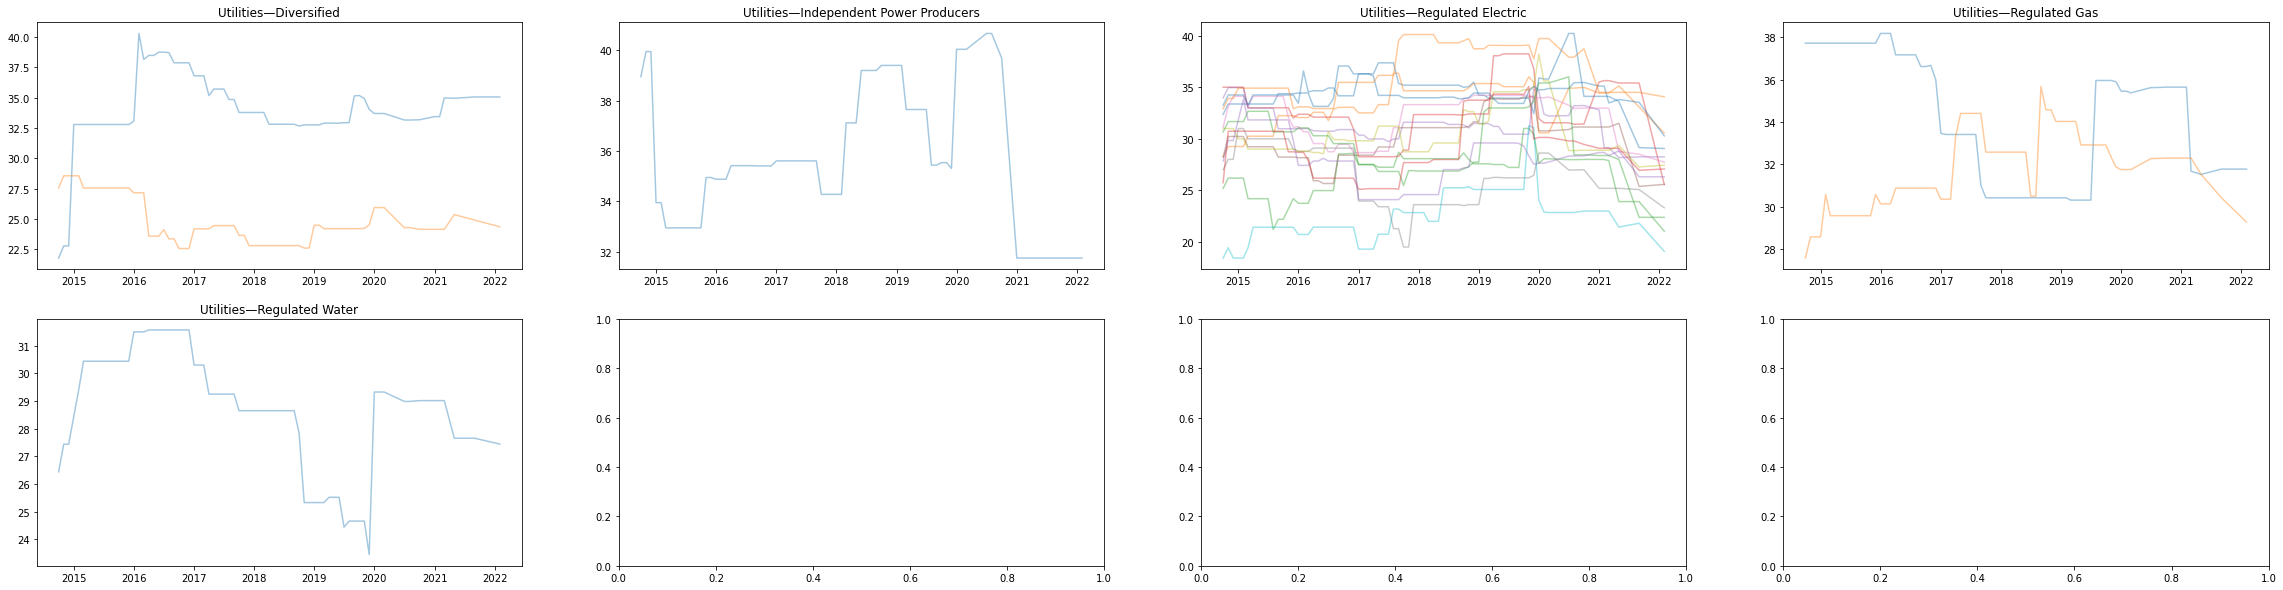

In [121]:
plot_esg_industry('Utilities', asset_profiles, esg_pivot_shifted)

# Basic Materials

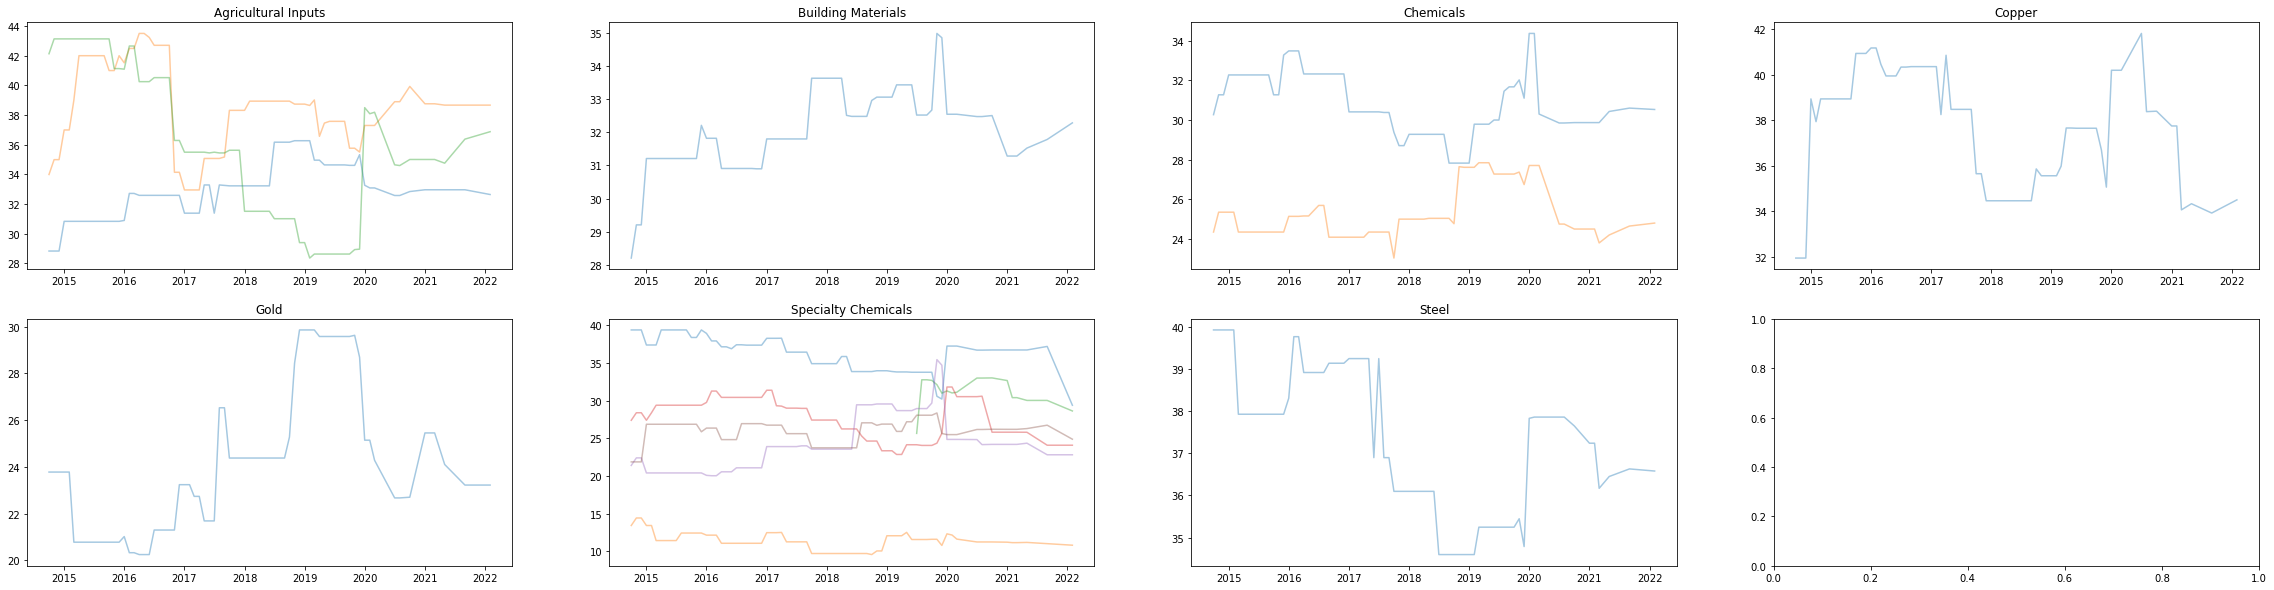

In [122]:
plot_esg_industry('Basic Materials', asset_profiles, esg_pivot_shifted)

# Financial Services

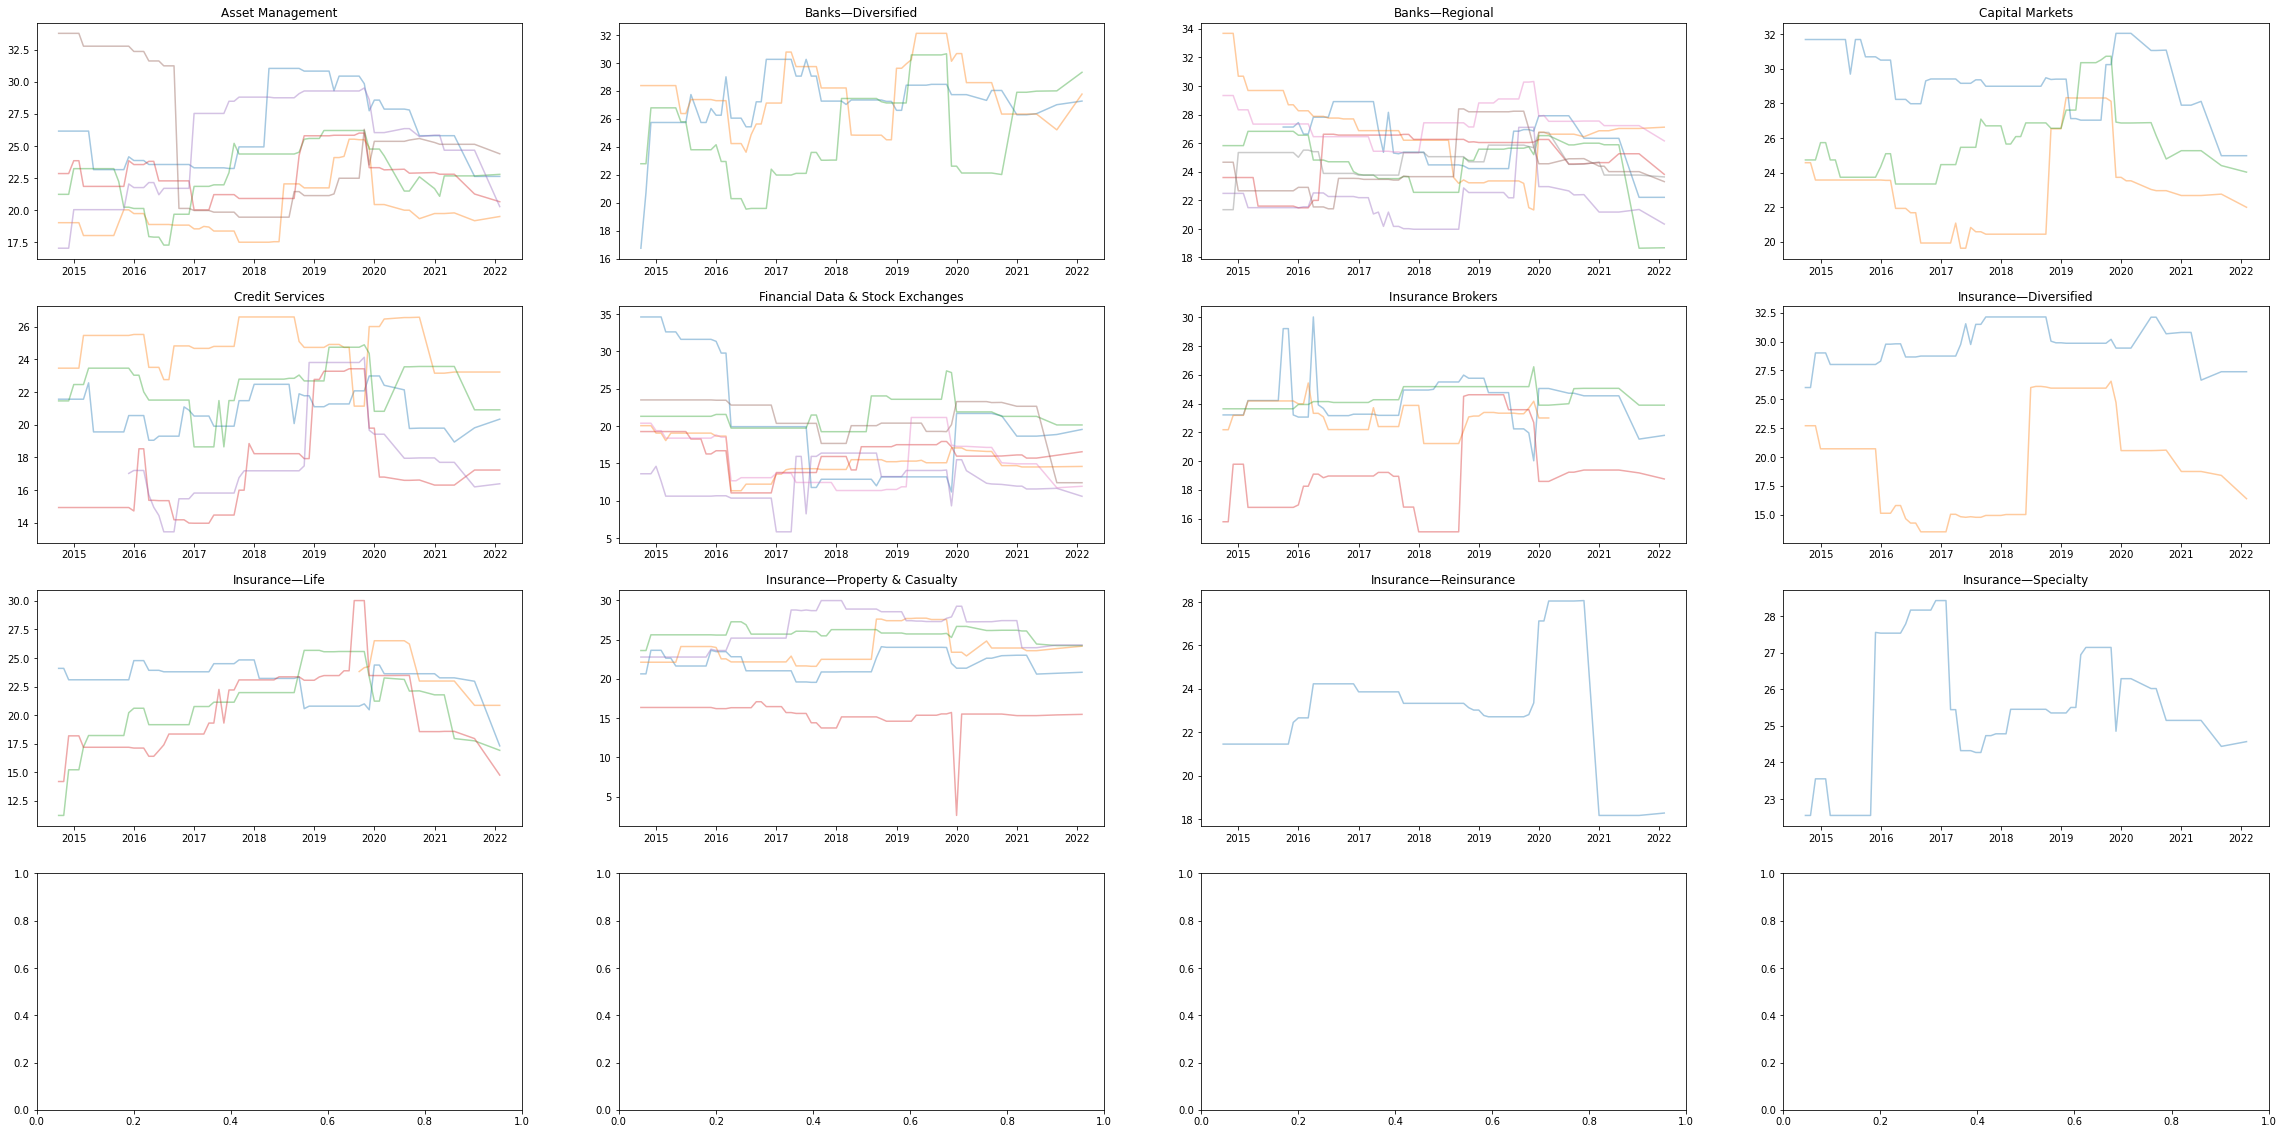

In [123]:
plot_esg_industry('Financial Services', asset_profiles, esg_pivot_shifted)

# Consumer Defensive

No esg data on companies in industry Food Distribution


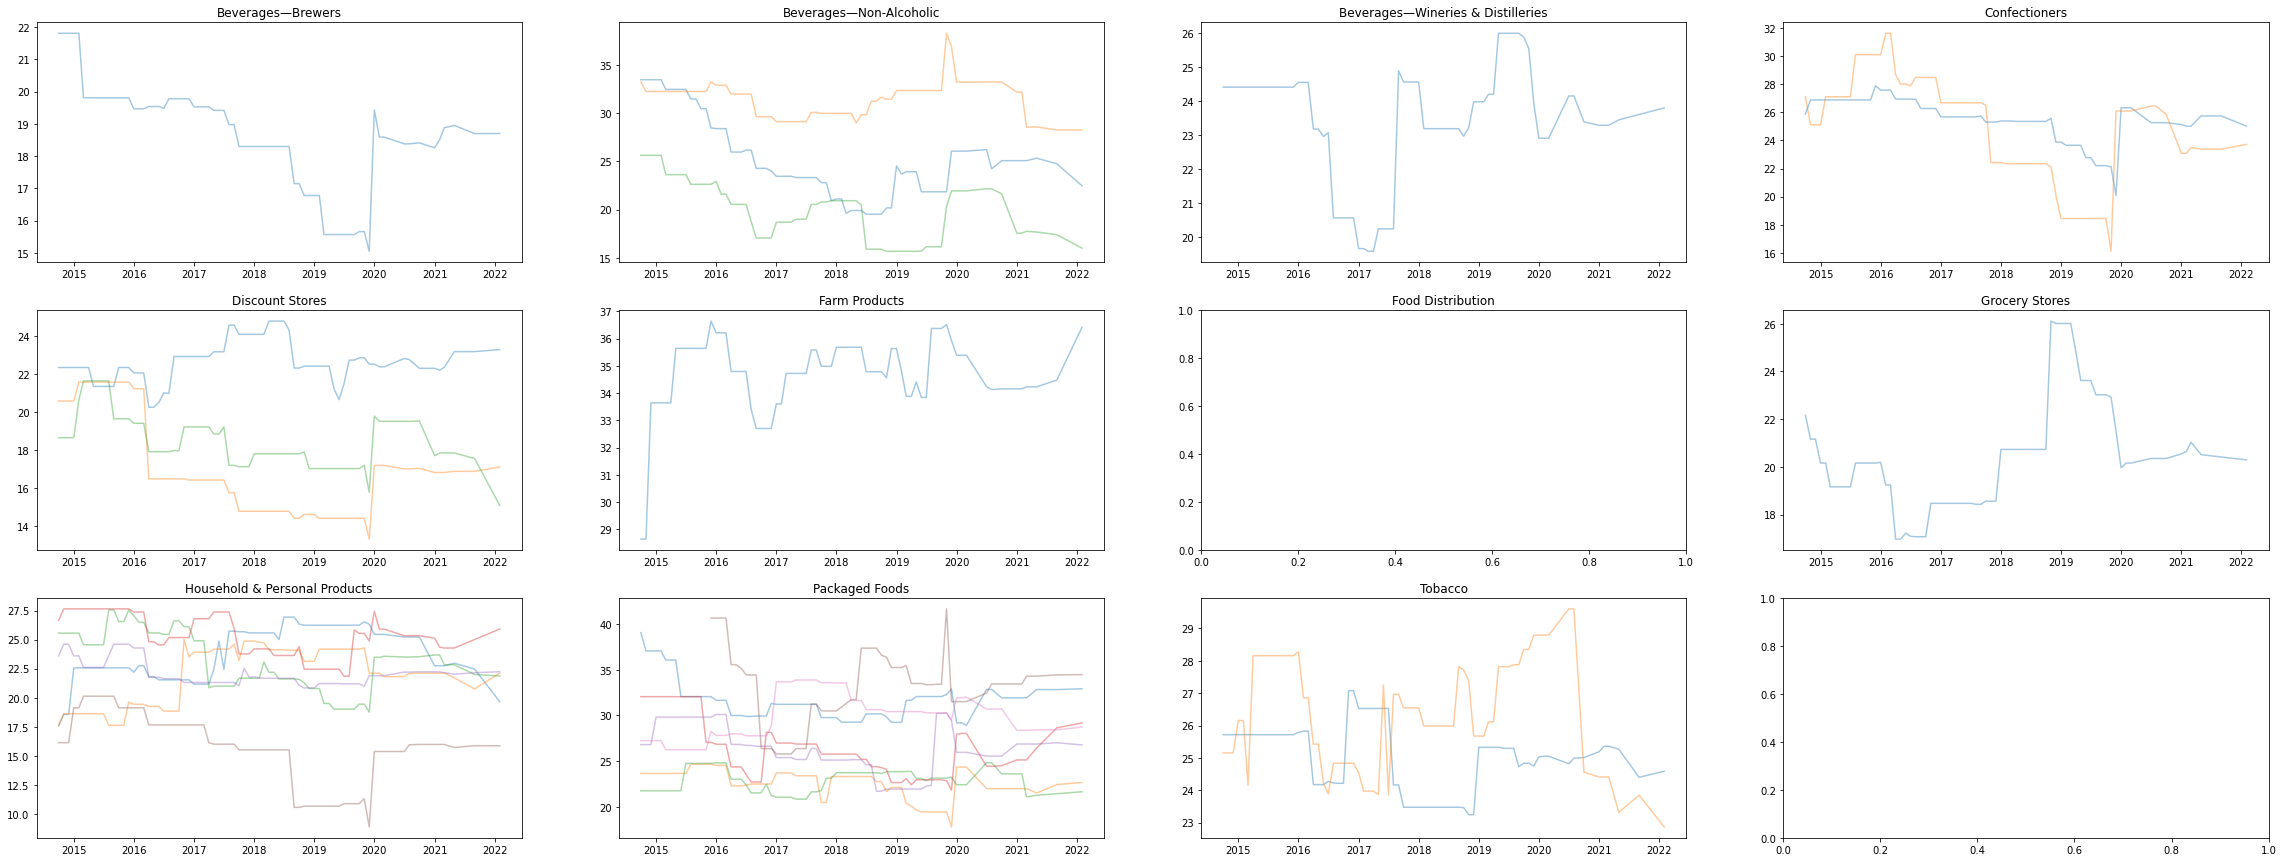

In [124]:
plot_esg_industry('Consumer Defensive', asset_profiles, esg_pivot_shifted)

# Consumer Cyclical

No esg data on companies in industry Apparel Manufacturing
No esg data on companies in industry Apparel Retail
No esg data on companies in industry Luxury Goods
No esg data on companies in industry Personal Services


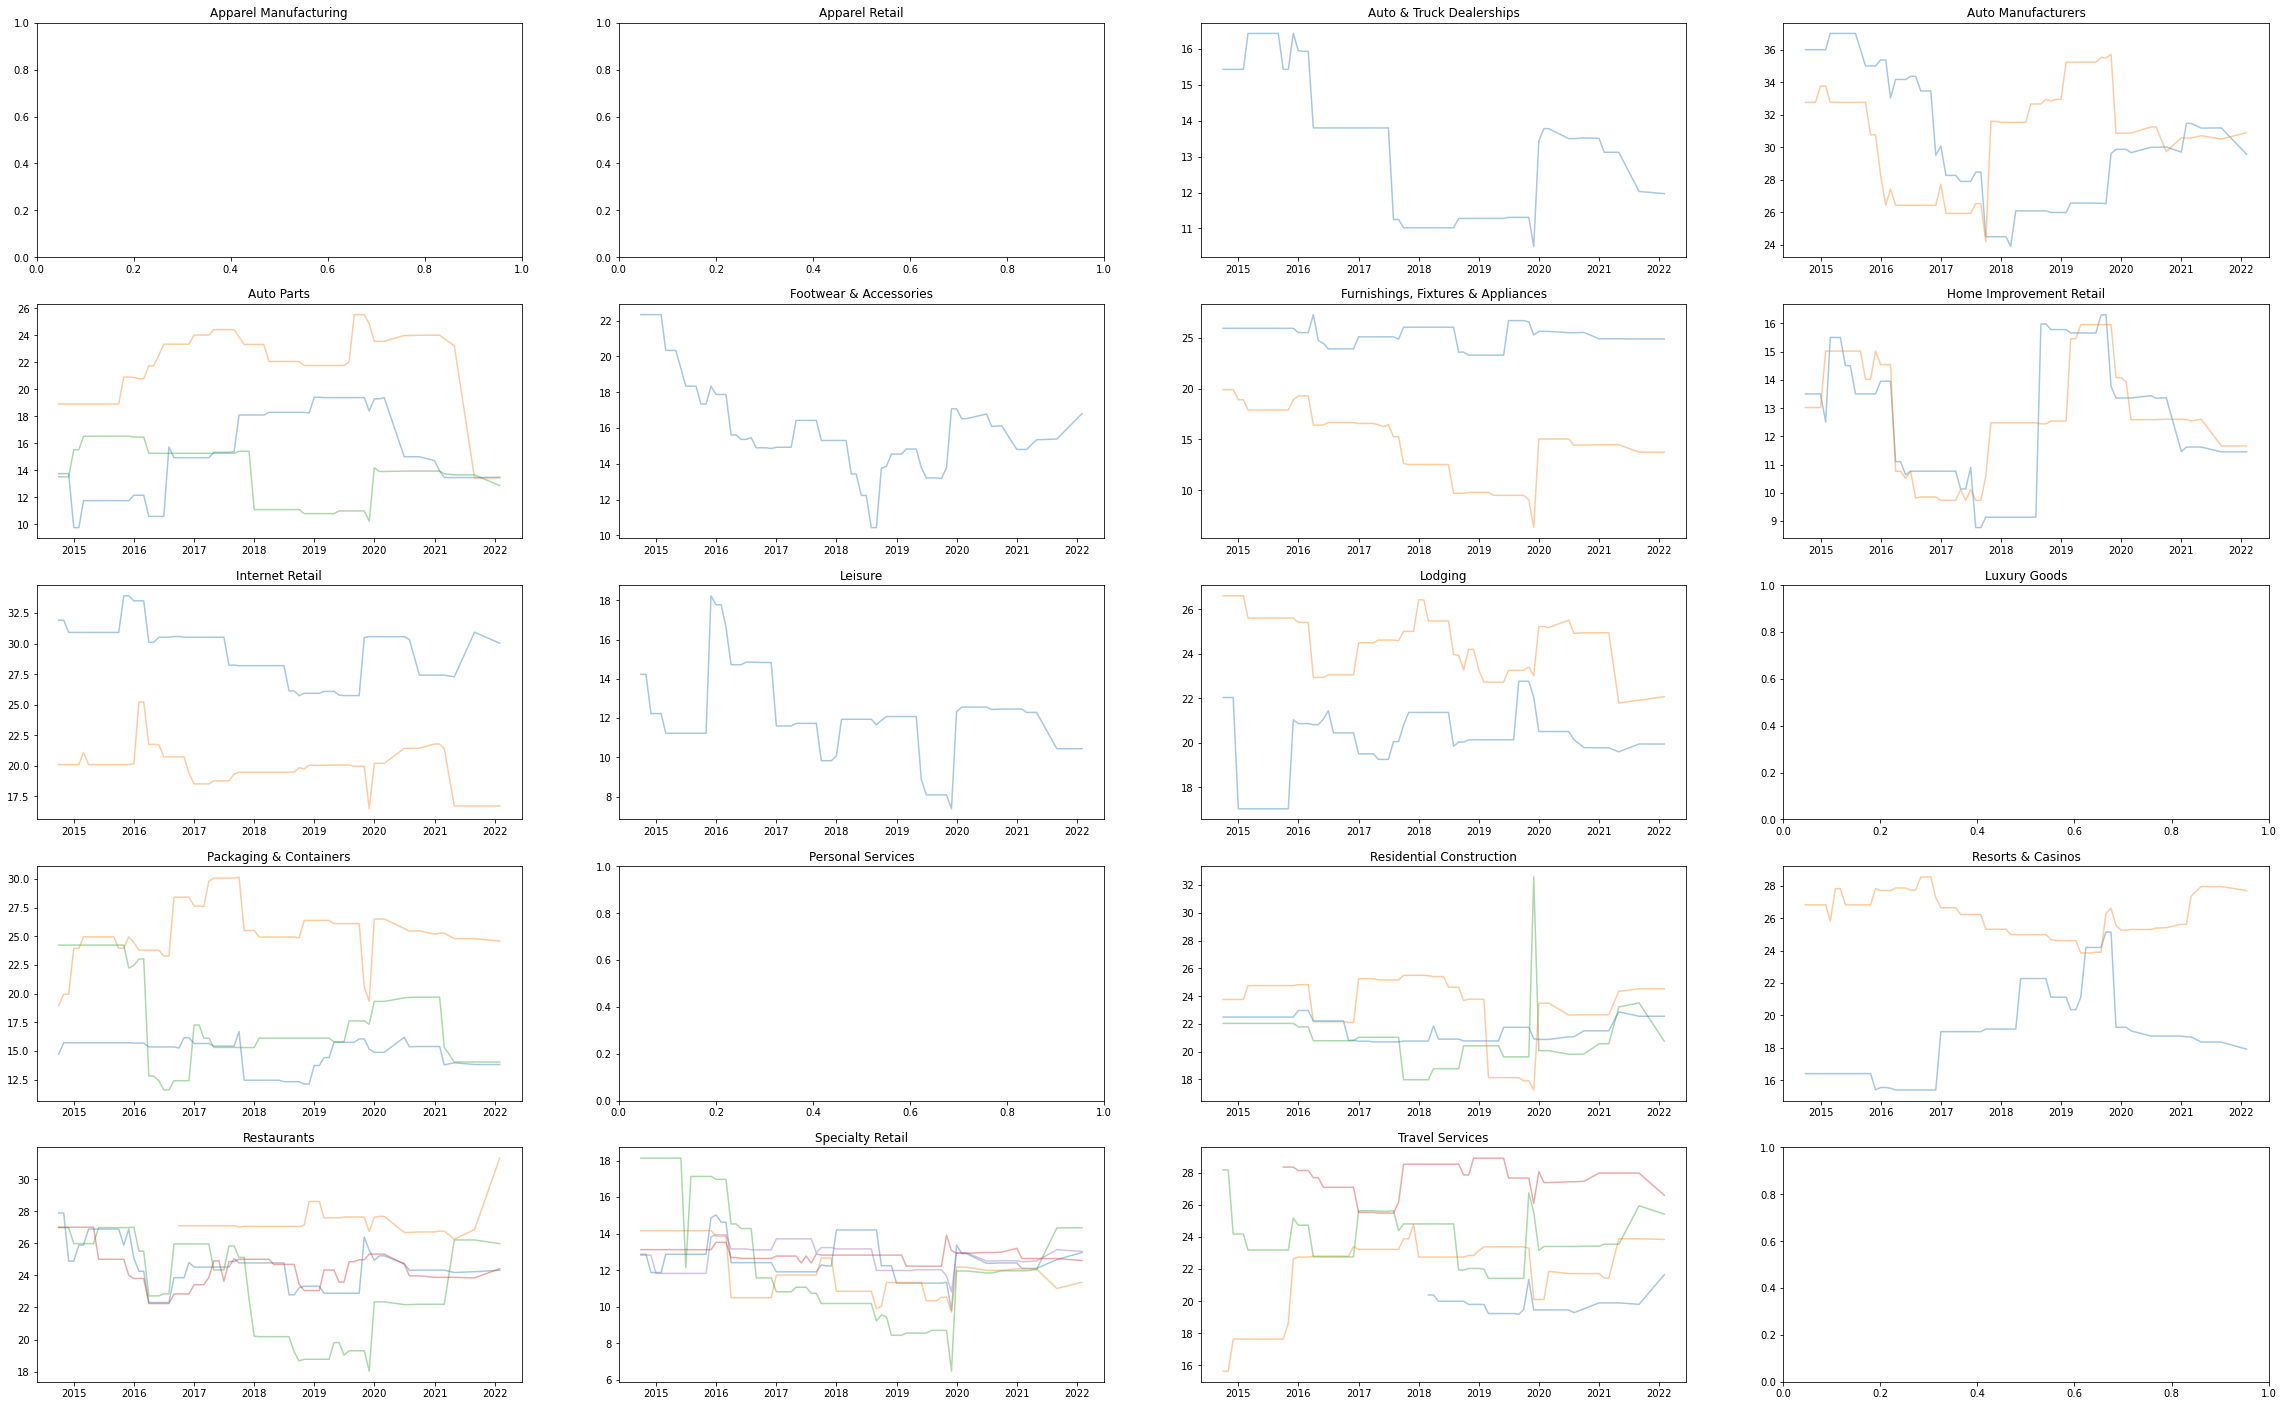

In [126]:
plot_esg_industry('Consumer Cyclical', asset_profiles, esg_pivot_shifted)

In [120]:
sector_classification.keys()

dict_keys(['Healthcare', 'Industrials', 'Consumer Cyclical', 'Technology', 'Consumer Defensive', 'Utilities', 'Financial Services', 'Basic Materials', 'Real Estate', 'Energy', 'Communication Services'])